In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import os
from pathlib import Path
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
class BankLogoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        # Get all bank folders
        self.banks = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {bank: idx for idx, bank in enumerate(sorted(self.banks))}

        # Initialize lists to store paths and labels
        self.image_paths = []
        self.labels = []

        # Collect paths and labels
        for bank in self.banks:
            bank_dir = self.root_dir / bank
            if not bank_dir.exists():
                print(f"Warning: {bank_dir} does not exist")
                continue

            for img_path in bank_dir.glob('*'):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif']:
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[bank])

        # Print dataset statistics
        # self._print_stats()

    def _print_stats(self):
        label_counts = Counter(self.labels)
        print("\nDataset Statistics:")
        print("------------------")
        for bank, idx in self.class_to_idx.items():
            count = label_counts[idx]
            print(f"{bank}: {count} images")
        print(f"Total: {len(self.labels)} images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            Image.MAX_IMAGE_PIXELS = None
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros((3, 224, 224)), label

In [4]:
class BankClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BankClassifier, self).__init__()
        # Load pre-trained ResNet50
        self.model = models.efficientnet_v2_l(pretrained=True)

        # Freeze early layers
        for param in list(self.model.parameters())[:-4]:
            param.requires_grad = False

        # Modify the final layer for our number of classes
        num_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Sequential(
            nn.Linear(num_features, 512),  # Increase width
            nn.ReLU(),
            nn.BatchNorm1d(512),          # Add batch normalization
            nn.Dropout(0.3),              # Try different dropout rates
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [14]:
def get_transforms(train=True):
    """Get transforms with heavy augmentation for training"""
    if train:
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1, 0.1),  # Random translation
                scale=(0.9, 1.1),      # Random scaling
                shear=10               # Random shearing
            ),
            transforms.ColorJitter(
                brightness=0.3,
                contrast=0.3,
                saturation=0.2,
                hue=0.1
            ),
            transforms.RandomGrayscale(p=0.1),  # Randomly convert to grayscale
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

In [6]:
def create_balanced_sampler(dataset):
    """Create a weighted sampler to balance the dataset"""
    class_counts = Counter(dataset.labels)
    weights = [1.0 / class_counts[label] for label in dataset.labels]
    weights = torch.DoubleTensor(weights)

    sampler = WeightedRandomSampler(
        weights=weights,
        num_samples=len(dataset) * 2,  # Oversample to 2x the original dataset size
        replacement=True
    )

    return sampler

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    """Train the model with validation and early stopping"""
    best_val_acc = 0.0
    patience = 5  # Number of epochs to wait for improvement
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_acc = 100. * train_correct / train_total
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100. * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}%')

        # Save best model and check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            '''torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
            }, 'best_bank_classifier.pth')'''
            patience_counter = 0
        else:
            patience_counter += 1

        '''if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break'''

    return train_losses, val_losses, train_accs, val_accs

In [8]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation losses and accuracies"""
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss') 
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Using device: cuda


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50:
Train Loss: 3.675 | Train Acc: 4.74%
Val Loss: 3.600 | Val Acc: 3.90%
Epoch 2/50:
Train Loss: 3.274 | Train Acc: 15.46%
Val Loss: 3.488 | Val Acc: 16.16%
Epoch 3/50:
Train Loss: 2.984 | Train Acc: 23.96%
Val Loss: 3.338 | Val Acc: 22.56%
Epoch 4/50:
Train Loss: 2.633 | Train Acc: 38.58%
Val Loss: 3.158 | Val Acc: 30.08%
Epoch 5/50:
Train Loss: 2.460 | Train Acc: 44.01%
Val Loss: 2.951 | Val Acc: 38.72%
Epoch 6/50:
Train Loss: 2.297 | Train Acc: 46.94%
Val Loss: 2.759 | Val Acc: 46.80%
Epoch 7/50:
Train Loss: 2.071 | Train Acc: 53.76%
Val Loss: 2.550 | Val Acc: 50.97%
Epoch 8/50:
Train Loss: 1.953 | Train Acc: 57.10%
Val Loss: 2.359 | Val Acc: 56.82%
Epoch 9/50:
Train Loss: 1.812 | Train Acc: 60.86%
Val Loss: 2.168 | Val Acc: 67.13%
Epoch 10/50:
Train Loss: 1.578 | Train Acc: 67.69%
Val Loss: 1.974 | Val Acc: 71.31%
Epoch 11/50:
Train Loss: 1.579 | Train Acc: 67.55%
Val Loss: 1.810 | Val Acc: 71.03%
Epoch 12/50:
Train Loss: 1.479 | Train Acc: 70.61%
Val Loss: 1.685 | Val Acc

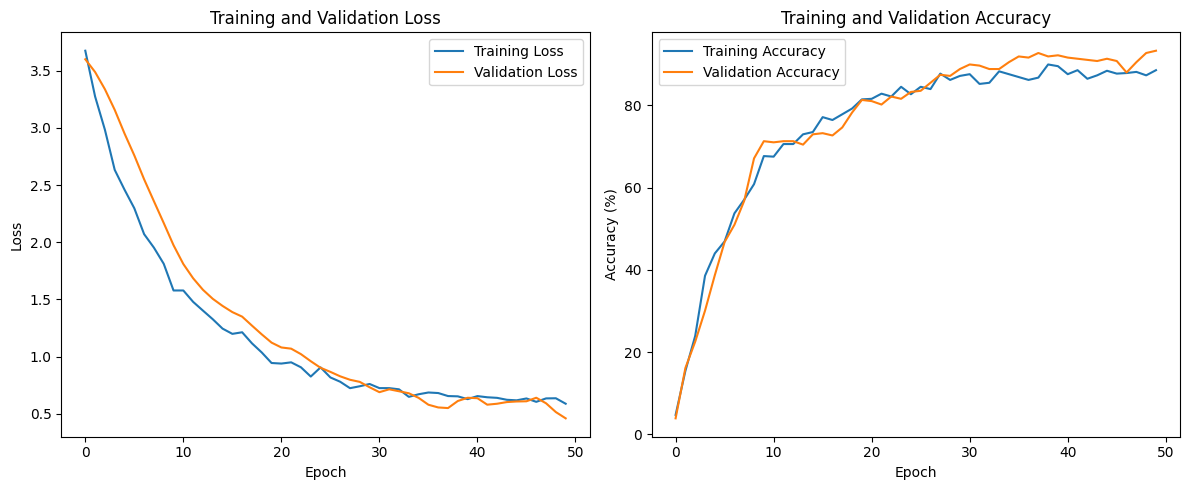

Training completed!
Model saved as 'best_bank_classifier.pth'
Training plot saved as 'training_history.png'


In [16]:
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Dataset paths
    data_dir = "/kaggle/input/bank-logos/logos"  # Update this path

    # Create full dataset
    full_dataset = BankLogoDataset(data_dir, transform=None)

    # Split indices for train/val
    train_indices, val_indices = train_test_split(
        range(len(full_dataset)),
        test_size=0.2,
        stratify=full_dataset.labels,
        random_state=42
    )

    # Create train and validation datasets
    train_dataset = BankLogoDataset(data_dir, transform=get_transforms(train=True))
    val_dataset = BankLogoDataset(data_dir, transform=get_transforms(train=False))

    # Create balanced sampler for training
    train_sampler = create_balanced_sampler(train_dataset)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=128,
        sampler=train_sampler,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Initialize model
    num_classes = len(full_dataset.banks)
    model = BankClassifier(num_classes).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.05)

    # Train model
    train_losses, val_losses, train_accs, val_accs = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        num_epochs=50
    )

    # Plot training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs)

    print("Training completed!")
    print(f"Model saved as 'best_bank_classifier.pth'")
    print(f"Training plot saved as 'training_history.png'")

if __name__ == '__main__':
    main()